# Multi-Scenario MORDM

## Imports

In [64]:
# Standard Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import networkx as nx
import scipy as sp
import plotly.express as px


# Workbench Imports
from ema_workbench import (Model, MultiprocessingEvaluator, ScalarOutcome, RealParameter, IntegerParameter, CategoricalParameter, optimize, Scenario, Constant, ema_logging,perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator, BaseEvaluator
from ema_workbench.analysis import parcoords


ema_logging.log_to_stderr(ema_logging.INFO)


<Logger EMA (DEBUG)>

## Model Specification

In [2]:
# Model Imports
from dike_model_function import DikeNetwork
from problem_formulation import get_model_for_problem_formulation

dike_model, planning_steps = get_model_for_problem_formulation(6)

In [3]:
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Specify reference scenario
Firstly, we load the results from the open exploration with no action taken to select a reference scenario that shows the most expected number of deaths. This, so-to-say worst-case scenario is then used to find the optimal policies using the MORDM approach.  

In [4]:
experiments, outcomes = load_results("../results/500Scenarios_NoAction_PF1.tar.gz")

[MainProcess/INFO] results loaded succesfully from /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/500Scenarios_NoAction_PF1.tar.gz


In [5]:
outcomes_df = pd.DataFrame(outcomes)

#Get index of worst scenario
index_wc = outcomes_df.sort_values("Expected Number of Deaths").tail(1).index

experiment_wc = experiments.iloc[index_wc]

In [6]:
reference_scenarios = [Scenario(f"{index}", **row) for index, row in experiment_wc.iloc[0:,0:19].iterrows()]

## Run Optimization on Worst Case Reference Scenario

In [14]:
ema_logging.log_to_stderr(ema_logging.INFO)

convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    results_epsilon_0_1 = evaluator.optimize(nfe=5000, epsilons=[0.1,]*len(dike_model.outcomes), 
    reference = reference_scenarios[0], convergence= convergence_metrics, searchover="levers")

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] generation 5: 499/5000 nfe
[MainProcess/INFO] generation 10: 997/5000 nfe
[MainProcess/INFO] generation 15: 1495/5000 nfe
[MainProcess/INFO] generation 20: 1994/5000 nfe
[MainProcess/INFO] generation 25: 2491/5000 nfe
[MainProcess/INFO] generation 30: 2991/5000 nfe
[MainProcess/INFO] generation 35: 3485/5000 nfe
[MainProcess/INFO] generation 40: 3983/5000 nfe
[MainProcess/INFO] generation 45: 4480/5000 nfe
[MainProcess/INFO] generation 50: 4980/5000 nfe
[MainProcess/INFO] optimization completed, found 440 solutions
[MainProcess/INFO] terminating pool


In [15]:
# Save Results
save_results(results_epsilon_0_1, "../results/5000nfe_BaseCaseMORDM.tar.gz")

[MainProcess/INFO] results saved successfully to /Users/ricoherzog/OneDrive/Uni/2019-2020 WiSe Den Haag/Q4/EPA1361 Model Based Decision Making/05_Project/model-based-decision-making/results/5000nfe_BaseCaseMORDM.tar.gz


### Check for Convergence
The optimization algorithm is now checked for convergence based on the Epsilon progress 

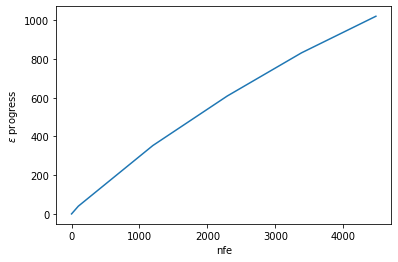

In [27]:
results, convergence = results_epsilon_0_1


plt.plot(convergence.nfe, convergence.epsilon_progress)
plt.ylabel('$\epsilon$ progress')
plt.xlabel('nfe')
plt.show()

## Show tradeoffs in the resulting optimal policies
The algorithm found 440 solutions. The

In [35]:
results.iloc[:, 31::]

,A1_2 Aggr Expected Annual Damage,A3 Expected Annual Damage,A1_2 Aggr Expected Number of Deaths,A3 Aggr Expected Number of Deaths,A1_5 Dike Investment Costs,Room for River Investment Costs,Evacuation Costs
0,1.076422e+08,7.042847e+06,0.075577,0.012143,2.406342e+09,30700000.0,0.000000
1,0.000000e+00,2.424784e+07,0.000000,0.005160,2.588652e+09,0.0,1030.416910
2,0.000000e+00,7.088503e+08,0.000000,1.153094,2.769170e+09,0.0,0.000000
3,0.000000e+00,0.000000e+00,0.000000,0.000000,2.209217e+09,146000000.0,0.000000
4,5.131469e+07,0.000000e+00,0.043614,0.000000,2.902977e+09,0.0,0.000000
...,...,...,...,...,...,...,...
435,6.495363e+06,7.159783e+07,0.006039,0.119029,1.160219e+09,704500000.0,0.000000
436,4.940846e+07,1.705379e+09,0.034607,2.473205,8.515504e+08,84600000.0,0.000000
437,3.508968e+07,1.697558e+08,0.021355,0.267392,9.761107e+08,432800000.0,0.000000
438,1.959203e+08,8.513779e+08,0.162442,1.170869,7.875309e+08,146000000.0,0.000000


In [73]:
fig = px.parallel_coordinates(results.iloc[:, 31::], labels= {"A1_2 Aggr Expected Annual Damage" : "A1 & 2 Damage", "A3 Expected Annual Damage" : "A3 Damage", "A1_2 Aggr Expected Number of Deaths" : "A1 & 2 Casualties", "A3 Aggr Expected Number of Deaths" : "A3 Casualties", "A1_5 Dike Investment Costs" : "Investment Costs", "Room for River Investment Costs" : "RfR Investment Costs"}, color=results.index)
fig.update_layout(showlegend=False)
fig.show()

To show the tradeoffs more clearly, we aggregate the costs and the expected number of casualties, as well as the investment costs with the evacuation costs

In [63]:
results_agg = results.iloc[:, 31::]
results_agg["Expected Casualties"] = results_agg["A1_2 Aggr Expected Number of Deaths"] + results_agg["A3 Aggr Expected Number of Deaths"]
results_agg["Expected Damage"] = results_agg["A1_2 Aggr Expected Annual Damage"] + results_agg["A3 Expected Annual Damage"]
results_agg["Traditional Costs"] = results_agg["A1_5 Dike Investment Costs"] + results_agg["Evacuation Costs"]


In [71]:
fig = px.parallel_coordinates(results_agg, dimensions=["Expected Casualties","Expected Damage", "Traditional Costs", "Room for River Investment Costs"], color = results_agg.index)
fig.update_layout(showlegend=False)
fig.show()